# Bond graph modelling of liver circulation
In this notebook, we provide a tutorial on modelling circulatory processes using bond graphs. We use BondGraphTools as the package for defining and simulating bond graph models, and construct two circulation models: a simple model of the $\pi$ filter and a more complex model of the three major vasculatures of the liver.

We first import the dependencies below.

In [1]:
import BondGraphTools as bgt
from BondGraphTools import new, connect, add, simulate
from matplotlib import pyplot as plt
import numpy as np

## The $\pi$-filter
The $\pi$-filter is a commonly-used building block for the vessel structure within the liver. A bond graph of the $\pi$-filter is shown below. Note that the filter has been coupled to a constant pressure (Se:Pin) as an input and a load resistance (R:RL) as an output.


![](pi_filter.svg)

We first define a new bond graph model for the $\pi$-filter.

In [2]:
bg = new(name="pi-filter")

Next we define the components in the model, along with their parameter values.

In [3]:
Se = new("Se",value=1)
Pa = new("0","Pa")
fa = new("1","fa")
ca = new("C","Ca",value=1)
rpa = new("R","Rpa",value=1)
Pb = new("0","Pb")
fb = new("1","fb")
cb = new("C","Cb",value=1)
rpb = new("R","Rpb",value=1)
fs = new("1","fs")
l = new("I","Ls",value=1)
r = new("R","Rs",value=1)
rl = new("R","RL",value=1)

We then add the components to the model.

In [4]:
add(bg,[Se,Pa,fa,ca,rpa,Pb,fb,cb,rpb,fs,l,r,rl])

The components are then connected together, which fully defines the model.

In [5]:
connect(Se, Pa)
connect(Pa, fa)
connect(fa, ca)
connect(fa, rpa)
connect(Pa, fs)
connect(fs, l)
connect(fs, r)
connect(fs, Pb)
connect(Pb, fb)
connect(fb, cb)
connect(fb, rpb)
connect(Pb, rl)

The `bgt.draw` function outputs a graphical representation of the system.

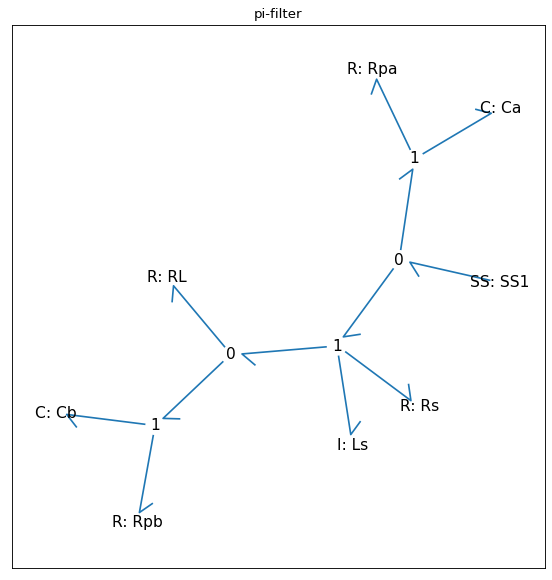

In [6]:
bgt.draw(bg)

The `constitutive_relations` method displays the equations for the model

In [7]:
bg.constitutive_relations

[dx_0 + x_0 - 1, dx_1 + x_1/2 - x_2/2, dx_2 + x_1/2 + 3*x_2/2 - 1]

The state variables are defined as shown below. Here the state variables are mapped as $(x_0,x_1,x_2) = (q_{Ca},q_{Cb},p_L)$.

In [8]:
bg.state_vars

{'x_0': (C: Ca, 'q_0'), 'x_1': (C: Cb, 'q_0'), 'x_2': (I: Ls, 'p_0')}

We use the `simulate` function to run a dynamic simulation of the model, with initial conditions $(q_{Ca},q_{Cb},p_L) = (2,2,2)$. The results are plotted below.

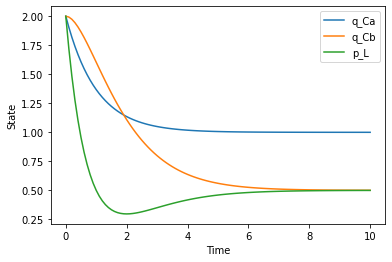

In [9]:
x0 = [2,2,2]
tspan = (0,10)
t,x = simulate(bg,tspan,x0)
plt.plot(t,x)
plt.xlabel("Time")
plt.ylabel("State")
plt.legend(["q_Ca","q_Cb","p_L"])
plt.show()

## Liver circulation

We now consider a more complex example of liver circulation, accounting for the hepatic artery, portal vein and hepatic vein. A bond graph is shown below.

![](liver_circulation.svg)

Since there are three arms with identical structure, we can exploit this by creating a function `add_pi_filter` that automatically creates and connects the components together.

In [10]:
def add_pi_filter(bg,vessel_name,C=1,Rp=1,L=1,R=1):
    Pa = new("0","Pa_"+vessel_name)
    fa = new("1","fa_"+vessel_name)
    ca = new("C",vessel_name+"_a",value=C)
    rpa = new("R",vessel_name+"_a",value=Rp)
    Pb = new("0","Pb_"+vessel_name)
    fb = new("1","fb_"+vessel_name)
    cb = new("C",vessel_name+"_b",value=C)
    rpb = new("R",vessel_name+"_b",value=Rp)
    fs = new("1","fs_"+vessel_name)
    l = new("I",vessel_name,value=L)
    r = new("R",vessel_name,value=R)

    add(bg,[Pa,fa,ca,rpa,Pb,fb,cb,rpb,fs,l,r])

    connect(Pa, fa)
    connect(fa, ca)
    connect(fa, rpa)
    connect(Pa, fs)
    connect(fs, l)
    connect(fs, r)
    connect(fs, Pb)
    connect(Pb, fb)
    connect(fb, cb)
    connect(fb, rpb)

    return Pa,Pb

We use the function above to define and draw the liver circulation model, using parameters from Ho et al. (2013; https://www.doi.org/10.1016/j.medengphy.2012.10.008). Since the driving pressures Se:DC and Se:PC are model inputs, we leave their values unspecified.

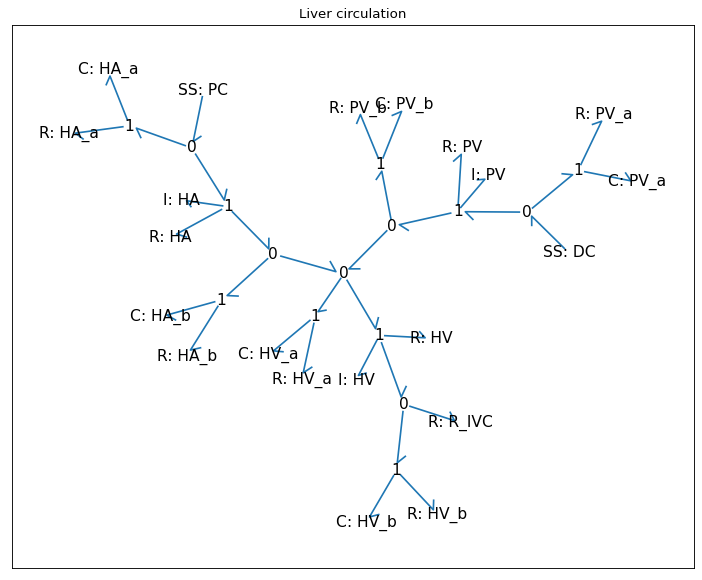

In [11]:
bg_liver = new(name="Liver circulation")
PVa,PVb = add_pi_filter(bg_liver,"PV",
    C=9.4995E-9,Rp=2.1054E8,L=50E6,R=37.807E6)
HAa,HAb = add_pi_filter(bg_liver,"HA",
    C=1.2803E-10,Rp=1.56198E10,L=200E6,R=1.8931E9)
HVa,HVb = add_pi_filter(bg_liver,"HV",
    C=1.4224E-7,Rp=1.40607E7,L=30E6,R=10.857E6)
connect(PVb,HVa)
connect(HAb,HVa)

DC = new("Se","DC",value=None)
PC = new("Se","PC",value=None)
rl = new("R","R_IVC",value=16.5E6)
add(bg_liver,[DC,PC,rl])
connect(DC,PVa)
connect(PC,HAa)
connect(HVb,rl)

bgt.draw(bg_liver)


The state variables are defined as follows


In [12]:
bg_liver.state_vars

{'x_0': (C: PV_a, 'q_0'),
 'x_1': (C: PV_b, 'q_0'),
 'x_2': (I: PV, 'p_0'),
 'x_3': (C: HA_a, 'q_0'),
 'x_4': (C: HA_b, 'q_0'),
 'x_5': (I: HA, 'p_0'),
 'x_6': (C: HV_a, 'q_0'),
 'x_7': (C: HV_b, 'q_0'),
 'x_8': (I: HV, 'p_0')}

The control variables (i.e. the driving pressures of the hepatic artery and portal vein) are defined below.

In [13]:
bg_liver.control_vars

{'u_0': (SS: DC, 'e'), 'u_1': (SS: PC, 'e')}

We can then run simulations of the model under a set of initial conditions. Note that the driving pressures need to be specified for the simulation to run. In this case, a constant pressure 10 mmHg is used for the Se:DC component for the portal vein (`u_0`) whereas an oscillatory pressure $100+20\sin(2.4 \pi t)$ mmHg is used for the Se:PC for the hepatic artery (`u_1`). The states are plotted below.

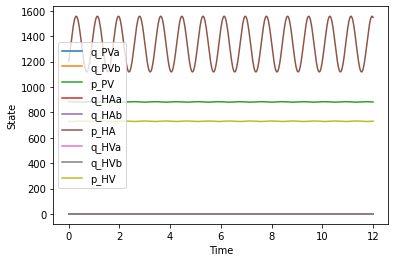

In [14]:
x0 = [1.26649234e-05, 6.31818986e-06, 8.84153043e+02, 1.68437957e-06,
       8.51537172e-08, 1.20202442e+03, 9.46049064e-05, 5.71304086e-05,
       7.28627995e+02]
tspan=(0,12)
mmHg_to_Pa = 133.322
t,x = simulate(bg_liver,tspan,x0,dt=0.02,
    control_vars={"u_0":mmHg_to_Pa*10,"u_1":f"{mmHg_to_Pa}*(100+20*sin(1.2*2*pi*t))"})
plt.plot(t,x)
plt.xlabel("Time")
plt.ylabel("State")
plt.legend(["q_PVa","q_PVb","p_PV","q_HAa","q_HAb","p_HA","q_HVa","q_HVb","p_HV"])
plt.show()

Below, we plot the flow rates through each of the vessels. As noted physiologically, the hepatic vein has the highest flow rate and the hepatic artery flow has the most pronounced oscillations.

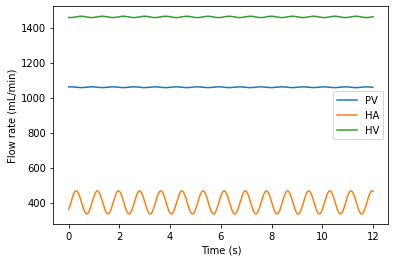

In [15]:
plt.figure()
f_PV = np.array(x)[:,2]/(bg_liver/"I:PV").params["L"]
f_HA = np.array(x)[:,5]/(bg_liver/"I:HA").params["L"]
f_HV = np.array(x)[:,8]/(bg_liver/"I:HV").params["L"]
plt.plot(t,f_PV*1e6*60,label="PV")
plt.plot(t,f_HA*1e6*60,label="HA")
plt.plot(t,f_HV*1e6*60,label="HV")
plt.xlabel("Time (s)")
plt.ylabel("Flow rate (mL/min)")
plt.legend()
plt.show()